In [1]:
## System
import sys
import os
from collections import defaultdict
import itertools

## Pandas
import pandas as pd
import numpy as np

## Stats
import statsmodels.api as sm

## Plotting 
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

## Fig utils 
from fig_utils import get_score_bin

In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
## genic ConSplice file path
genic_consplice_file = "../data/ConSplice.gene.scores.autosome.txt"

In [3]:
## score columns
consplice_col = "weighted_sc_percentile"

In [4]:
## Read in the genic ConSplice scores into pandas data frame
ConSplice_df = pd.read_csv(genic_consplice_file, sep = "\t", index_col = False)

In [5]:
## Load the sOutlier gene set
soutilers_df = pd.read_csv("../data/gtexV8.sOutlier.stats.globalOutliers.removed.txt.gz", sep = "\t", index_col = False)

for col in soutilers_df.columns:
    if col != "Gene":
        soutilers_df[col] = soutilers_df[col].astype(float)

In [6]:
## sOutlier Counts

soutilers_count = soutilers_df.copy()
soutilers_count = soutilers_count.drop(["Gene"], axis =1)

In [7]:
## Filter using a p-value < 0.0027 established by Ferraro et al.

soutilers_df["sig_gene_ind_count"] = soutilers_count[soutilers_count < 0.0027].count(axis = 1)

In [8]:
## Combine sOutliers with ConSplice scores

soutilers_df.Gene = soutilers_df.Gene.apply(lambda x: x.strip().split(".")[0])

ConSplice_df.gene_id = ConSplice_df.gene_id.apply(lambda x: x.strip().split(".")[0])

soutilers_df = soutilers_df.rename(columns = {"Gene":"gene_id"})

ConSplice_df_with_outliers_df = pd.merge(ConSplice_df, soutilers_df[["gene_id","sig_gene_ind_count"]], on = "gene_id")

In [9]:
## Get the splicing constarint decile for each variant
ConSplice_df_with_outliers_df["constraint_percentile_bin"] = ConSplice_df_with_outliers_df.apply(get_score_bin, score_column = consplice_col, axis = 1)

In [10]:
## Get per bin proportion of genes

### Each bin will add to 1. That total of that bin will be split between the number of sOutliers per gene.

per_bin_totals = ConSplice_df_with_outliers_df.groupby(["constraint_percentile_bin"])["gene_id"].count().reset_index()

per_bin_totals = per_bin_totals.rename(columns = {"gene_id":"gene_totals"})

## Genes with == 0 sOutliers
count_df = ConSplice_df_with_outliers_df.loc[(ConSplice_df_with_outliers_df.sig_gene_ind_count == 0)].groupby(["constraint_percentile_bin"])["gene_id"].count().reset_index()
count_df = count_df.rename(columns = {"gene_id":"0"})
per_bin_totals = pd.merge(per_bin_totals,count_df, on = "constraint_percentile_bin",how = "outer")


## Genes with >= 1 sOutlier
count_df = ConSplice_df_with_outliers_df.loc[(ConSplice_df_with_outliers_df.sig_gene_ind_count >= 1)].groupby(["constraint_percentile_bin"])["gene_id"].count().reset_index()
count_df = count_df.rename(columns = {"gene_id":">=1"})
per_bin_totals = pd.merge(per_bin_totals,count_df, on = "constraint_percentile_bin",how = "outer")
    
per_bin_totals = per_bin_totals.fillna(0)

In [11]:
## Get normalized values
normalized_values = per_bin_totals["0"].values / per_bin_totals.gene_totals.values

In [12]:
## Ordinary Least Squares (OLS) Linear regression

## Genes with ZERO sig. sOutliers

zero_sig = pd.DataFrame({"bins":[float(x.strip().split("-")[0]) * 10 for x in per_bin_totals.constraint_percentile_bin.values.tolist()], "norm_values":[float(x) for x in normalized_values]})

X = zero_sig.bins
Y = zero_sig.norm_values
X2 = sm.add_constant(X)

est = sm.OLS(Y, X2)

est2 = est.fit()

In [13]:
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:            norm_values   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     98.94
Date:                Thu, 13 Jan 2022   Prob (F-statistic):           8.83e-06
Time:                        12:38:19   Log-Likelihood:                 29.587
No. Observations:                  10   AIC:                            -55.17
Df Residuals:                       8   BIC:                            -54.57
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8032      0.008     97.362      0.0

/Users/michaelcormier/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=10



In [14]:
print("OLS p-value: {}".format(est2.pvalues.bins))

OLS p-value: 8.831807497172846e-06


In [15]:
print("Adjusted $R^{2}$ = %.3f" %est2.rsquared_adj)

Adjusted $R^{2}$ = 0.916


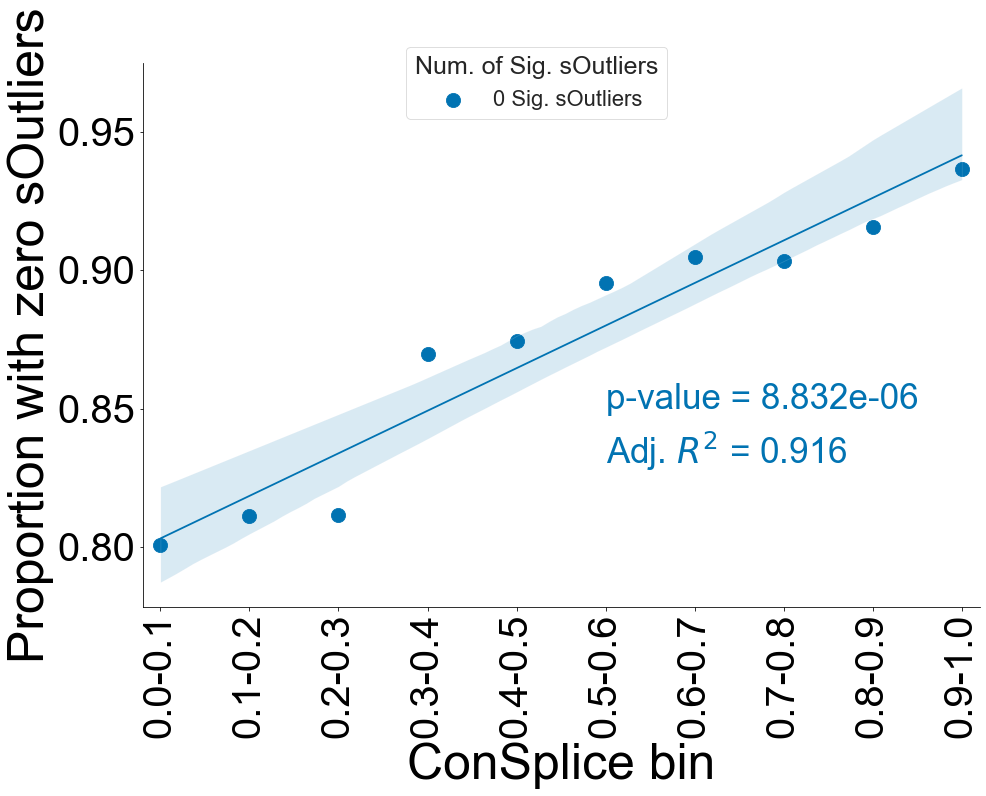

In [16]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

fig, ax = plt.subplots(figsize = (15,10))
sns.set(font='Arial', style = "white")
sns.set_context("paper", font_scale = 2)
sns.despine()

normalized_values = per_bin_totals["0"].values / per_bin_totals.gene_totals.values
plt.scatter(x = per_bin_totals.constraint_percentile_bin.values.tolist(), 
            y = normalized_values,
            s = 200,
            label = "0 Sig. sOutliers",
            color = sns.color_palette("colorblind")[0])

sns.regplot(x = "bins",
            y = "norm_values",
            data = zero_sig,
            scatter = False,
            color = sns.color_palette("colorblind")[0])

ax.text(5,0.85, "p-value = {:.3e}".format(est2.pvalues.bins), fontsize = 35, color = sns.color_palette("colorblind")[0])
ax.text(5,0.83, "Adj. $R^{2}$ = %.3f" %est2.rsquared_adj, fontsize = 35, color = sns.color_palette("colorblind")[0])


ax.tick_params(axis="x", labelsize=40, rotation=90 )
ax.tick_params(axis="y", labelsize=40)   
plt.xlabel("ConSplice bin",fontsize = 50)
plt.ylabel("Proportion with zero sOutliers", fontsize = 50)
plt.legend(title = "Num. of Sig. sOutliers", fontsize = 22, title_fontsize = 25, bbox_to_anchor=(0.64, 1.05))
plt.xlim(-0.2,9.2)

plt.savefig('../figures/figure2_C.svg')

In [17]:
## Get normalized values
normalized_values = per_bin_totals[">=1"].values / per_bin_totals.gene_totals.values

In [18]:
## Ordinary Least Squares (OLS) Linear regression

## Genes with ZERO sig. sOutliers

gt_eq_1_sig = pd.DataFrame({"bins":[float(x.strip().split("-")[0]) * 10 for x in per_bin_totals.constraint_percentile_bin.values.tolist()], "norm_values":[float(x) for x in normalized_values]})

X = gt_eq_1_sig.bins
Y = gt_eq_1_sig.norm_values
X2 = sm.add_constant(X)

est = sm.OLS(Y, X2)

gt_eq_1_est2 = est.fit()

In [19]:
print(gt_eq_1_est2.summary())

                            OLS Regression Results                            
Dep. Variable:            norm_values   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     98.94
Date:                Thu, 13 Jan 2022   Prob (F-statistic):           8.83e-06
Time:                        12:38:19   Log-Likelihood:                 29.587
No. Observations:                  10   AIC:                            -55.17
Df Residuals:                       8   BIC:                            -54.57
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1968      0.008     23.851      0.0

/Users/michaelcormier/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=10



In [20]:
print("OLS p-value: {}".format(est2.pvalues.bins))

OLS p-value: 8.831807497172846e-06


In [21]:
print("Adjusted $R^{2}$ = %.3f" %est2.rsquared_adj)

Adjusted $R^{2}$ = 0.916


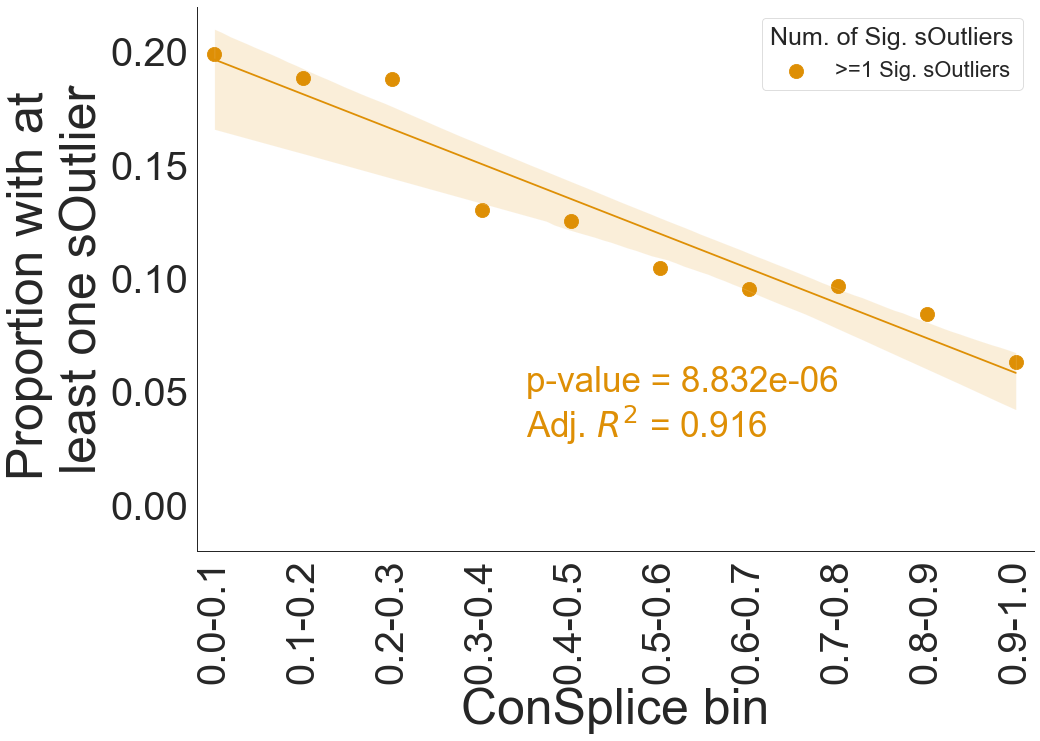

In [22]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

fig, ax = plt.subplots(figsize = (15,10))
sns.set(font='Arial', style = "white")
sns.set_context("paper", font_scale = 2)
sns.despine()

normalized_values = per_bin_totals[">=1"].values / per_bin_totals.gene_totals.values
plt.scatter(x = per_bin_totals.constraint_percentile_bin.values.tolist(), 
            y = normalized_values,
            s = 200,
            label = ">=1 Sig. sOutliers",
            color = sns.color_palette("colorblind")[1])

gt_eq_1 = pd.DataFrame({"bins":[float(x.strip().split("-")[0]) * 10 for x in per_bin_totals.constraint_percentile_bin.values.tolist()], "norm_values":[float(x) for x in normalized_values]})


sns.regplot(x = "bins",
            y = "norm_values",
            data = gt_eq_1,
            scatter = False,
            color = sns.color_palette("colorblind")[1])

ax.text(3.5,0.05, "p-value = {:.3e}".format(gt_eq_1_est2.pvalues.bins), fontsize = 35, color = sns.color_palette("colorblind")[1])
ax.text(3.5,0.03, "Adj. $R^{2}$ = %.3f" %gt_eq_1_est2.rsquared_adj, fontsize = 35, color = sns.color_palette("colorblind")[1])



ax.tick_params(axis="x", labelsize=40, rotation=90 )

ax.tick_params(axis="y", labelsize=40)   
plt.xlabel("ConSplice bin",fontsize = 50)
plt.ylabel("Proportion with at \nleast one sOutlier", fontsize = 50)
plt.legend(title = "Num. of Sig. sOutliers", fontsize = 22, title_fontsize = 25, bbox_to_anchor=(1., 1.0))
plt.ylim(-0.02,0.22)
plt.xlim(-0.2,9.2)

plt.savefig('../figures/suppl_figure5_B.svg')